# Experiment 15c: Anchored In-Context Learning (Ref: Appendix-N)

## Protocol for Trajectory-Aware Induction

---

## Post-Mortem: The "Context Mismatch" Bug (EXPT 15b)

In EXPT 15b, Momentum Attention performed **worse** than Baseline:
- Baseline L_rep: 1.65
- Momentum L_rep: 2.12 (+29% worse)

### The Physics of Failure

Momentum is defined kinematically as `p_t = q_t - q_{t-1}`. It encodes the **entry trajectory** into a token.

**In the Lesson (Context):** The chain `A→B...` is preceded by random noise `X`:
```
p_A^(lesson) = q_A - q_X
```

**In the Query (Test):** The query `A...` is preceded by different noise `Y`:
```
p_A^(query) = q_A - q_Y
```

Because `X ≠ Y`, the momentum vectors differ: `p_A^(lesson) ≠ p_A^(query)`

The attention mechanism, looking for a match in phase space `(q, p)`, **fails to recognize** the query as an instance of the lesson!

---

## The Fix: Anchored Chains

We introduce a special **Anchor Token (α)** that strictly precedes every chain definition and every query.

**The Physics of Anchoring:**
```
Pattern: [ANCHOR] → A → B → C ...

p_A^(lesson) = q_A - q_α
p_A^(query)  = q_A - q_α

Now: p_A^(lesson) ≡ p_A^(query)  ✓
```

The signal matches perfectly, and the Momentum filter amplifies the induction head.

---

## Theoretical Implication

If Momentum succeeds here (after failing in EXPT 15b), it proves:

> **Momentum Attention is a Tri-Gram Filter.** It doesn't just associate `A → B`; it associates `(Prev, A) → B`. This makes it strictly more selective than standard attention, suppressing "false positive" induction when the trajectory doesn't match.

---

**Hardware Target:** Google Colab A100 (40GB) or NVIDIA GB10

## 0. Colab Setup

In [ ]:
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    print("Running in Google Colab")
else:
    print("Running locally (GB10 or other)")

Running in Google Colab


## 1. Imports and Setup

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Optional, Dict, List, Tuple
import json
import os
from datetime import datetime
import math

try:
    from tqdm.notebook import tqdm
except ImportError:
    from tqdm import tqdm

# Reproducibility
torch.manual_seed(42)
np.random.seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

Device: cuda
GPU: NVIDIA A100-SXM4-40GB
Memory: 42.5 GB


## 2. Configuration

In [ ]:
@dataclass
class ExperimentConfig:
    """Configuration for EXPT 15c: Anchored ICL"""

    # Model Architecture
    vocab_size: int = 1000  # Token 999 reserved as ANCHOR
    d_model: int = 256
    n_layers: int = 4
    n_heads: int = 8
    d_head: int = 32
    d_ff: int = 1024
    max_seq_len: int = 512
    dropout: float = 0.1
    rope_base: float = 10000.0

    # Momentum Configuration
    gamma: float = 0.2  # Same as EXPT 15b for fair comparison
    beta: float = 0.0

    # Anchored ICL Dataset Configuration
    seq_length: int = 512
    chain_length: int = 10  # Same as EXPT 15b
    num_chains: int = 4
    chain_insert_prob: float = 0.4
    query_insert_prob: float = 0.4
    # Remaining 0.2 = noise

    # Training Configuration
    batch_size: int = 32
    n_train_steps: int = 10000
    learning_rate: float = 3e-4
    weight_decay: float = 0.01
    warmup_steps: int = 500
    eval_every: int = 500

    # Experiment
    experiment_name: str = "expt15c_anchored_icl"
    save_dir: str = "./expt15c_results"

config = ExperimentConfig()
os.makedirs(config.save_dir, exist_ok=True)

print(f"Experiment: {config.experiment_name}")
print(f"Model: d={config.d_model}, L={config.n_layers}, H={config.n_heads}")
print(f"Momentum: γ={config.gamma}")
print(f"Chain Length: {config.chain_length}")
print(f"ANCHOR Token ID: {config.vocab_size - 1}")
print(f"Training: {config.n_train_steps} steps, batch={config.batch_size}")

Experiment: expt15c_anchored_icl
Model: d=256, L=4, H=8
Momentum: γ=0.2
Chain Length: 10
ANCHOR Token ID: 999
Training: 10000 steps, batch=32


## 3. Anchored ICL Dataset (THE FIX)

**Key Change:** Every chain definition AND every query is preceded by the ANCHOR token.

This ensures **Kinematic Consistency**:
- `p_A^(lesson) = q_A - q_anchor`
- `p_A^(query) = q_A - q_anchor`
- Perfect match in phase space!

In [ ]:
class AnchoredICLDataset(Dataset):
    """
    Generates Anchored Chains to enforce Kinematic Consistency.

    Structure: [ANCHOR] → A → B → C ...

    The ANCHOR token ensures that the momentum vector p_A is identical
    whether A appears in a lesson or a query, enabling the Momentum
    Attention mechanism to correctly match patterns in phase space.
    """

    def __init__(self, config: ExperimentConfig, n_samples: int = 10000):
        self.config = config
        self.n_samples = n_samples
        self.chain_length = config.chain_length
        self.num_chains = config.num_chains

        # Reserve the LAST token ID as the special Anchor
        self.anchor_token = config.vocab_size - 1

        # Pre-generate all sequences
        self.sequences = self._generate_all_sequences()

    def _generate_all_sequences(self) -> torch.Tensor:
        sequences = []
        for _ in range(self.n_samples):
            seq = self._generate_single_sequence()
            sequences.append(seq)
        return torch.stack(sequences)

    def _generate_single_sequence(self) -> torch.Tensor:
        """
        Generate a sequence with ANCHORED chains.

        Key difference from EXPT 15b:
        - Every chain definition starts with [ANCHOR]
        - Every query starts with [ANCHOR]
        - This ensures kinematic consistency for momentum matching
        """
        cfg = self.config
        final_seq = []

        # 1. Create a pool of chains (sample from vocab EXCLUDING anchor)
        chains = []
        for _ in range(self.num_chains):
            # Sample unique tokens excluding the anchor token
            chain = np.random.choice(
                cfg.vocab_size - 1,  # Exclude anchor
                size=self.chain_length,
                replace=False
            )
            chains.append(chain)

        # 2. Build the sequence
        target_len = cfg.seq_length

        while len(final_seq) < target_len:
            r = np.random.random()

            if r < cfg.chain_insert_prob:
                # INSERT ANCHORED DEFINITION (The "Lesson")
                # Pattern: [ANCHOR] A B C D E F G H I J
                which_chain = chains[np.random.randint(0, self.num_chains)]

                final_seq.append(self.anchor_token)  # <--- THE FIX
                final_seq.extend(which_chain.tolist())

            elif r < cfg.chain_insert_prob + cfg.query_insert_prob:
                # INSERT ANCHORED QUERY (The "Test")
                # Pattern: [ANCHOR] A B C ... (partial chain)
                which_chain = chains[np.random.randint(0, self.num_chains)]

                # Start from a random position
                start = np.random.randint(0, self.chain_length - 1)
                # Take a chunk of 2-5 tokens
                chunk_len = np.random.randint(2, min(5, self.chain_length - start) + 1)
                chunk = which_chain[start:start + chunk_len]

                final_seq.append(self.anchor_token)  # <--- THE FIX
                final_seq.extend(chunk.tolist())

            else:
                # INSERT NOISE (No anchor - this is just distraction)
                noise_len = np.random.randint(5, 20)
                # Noise also excludes anchor to keep it special
                noise = np.random.randint(0, cfg.vocab_size - 1, size=noise_len)
                final_seq.extend(noise.tolist())

        return torch.tensor(final_seq[:target_len], dtype=torch.long)

    def __len__(self) -> int:
        return self.n_samples

    def __getitem__(self, idx: int) -> torch.Tensor:
        return self.sequences[idx]


# Test the dataset
print("Testing Anchored ICL Dataset...")
test_dataset = AnchoredICLDataset(config, n_samples=100)
sample = test_dataset[0]

print(f"Sample shape: {sample.shape}")
print(f"ANCHOR token ID: {config.vocab_size - 1}")

# Count anchor occurrences
anchor_count = (sample == config.vocab_size - 1).sum().item()
print(f"Anchor occurrences in sample: {anchor_count}")

# Show first 60 tokens with anchor highlighted
tokens = sample[:60].tolist()
highlighted = [f"[α]" if t == config.vocab_size - 1 else str(t) for t in tokens]
print(f"First 60 tokens: {' '.join(highlighted[:30])}")
print(f"                 {' '.join(highlighted[30:60])}")

Testing Anchored ICL Dataset...
Sample shape: torch.Size([512])
ANCHOR token ID: 999
Anchor occurrences in sample: 47
First 60 tokens: [α] 211 196 803 331 138 356 600 273 18 982 310 869 885 977 153 389 259 619 882 796 570 [α] 453 793 209 309 740 578 895
                 545 436 678 847 449 929 246 519 140 361 7 477 [α] 729 467 355 768 [α] 768 937 607 475 209 [α] 578 895 545 436 678 [α]


## 4. Rotary Position Embedding (RoPE)

In [ ]:
class RotaryPositionEmbedding(nn.Module):
    """
    Rotary Position Embedding (RoPE).
    Applied ONCE to position coordinates before momentum computation.
    """

    def __init__(self, d_head: int, max_seq_len: int = 2048, base: float = 10000.0):
        super().__init__()
        self.d_head = d_head

        # Compute inverse frequencies
        inv_freq = 1.0 / (base ** (torch.arange(0, d_head, 2).float() / d_head))
        self.register_buffer('inv_freq', inv_freq)

        # Precompute sin/cos
        t = torch.arange(max_seq_len).float()
        freqs = torch.einsum('i,j->ij', t, inv_freq)
        emb = torch.cat([freqs, freqs], dim=-1)
        self.register_buffer('cos_cached', emb.cos())
        self.register_buffer('sin_cached', emb.sin())

    def _rotate_half(self, x: torch.Tensor) -> torch.Tensor:
        x1 = x[..., :x.shape[-1] // 2]
        x2 = x[..., x.shape[-1] // 2:]
        return torch.cat([-x2, x1], dim=-1)

    def forward(self, x: torch.Tensor, seq_len: int = None) -> torch.Tensor:
        if seq_len is None:
            seq_len = x.shape[2]
        cos = self.cos_cached[:seq_len].unsqueeze(0).unsqueeze(0)
        sin = self.sin_cached[:seq_len].unsqueeze(0).unsqueeze(0)
        return (x * cos) + (self._rotate_half(x) * sin)


print("RoPE module defined ✓")

RoPE module defined ✓


## 5. Momentum-Augmented Multi-Head Attention

**Architecture:**
1. Shared weight matrices for Q, K, V
2. RoPE applied ONCE to position coordinates
3. Momentum: `p_t = q_t - q_{t-1}` (after RoPE)
4. Augmentation: `q̃ = q + γ·p`

**With anchoring, the momentum `p_A` is now consistent between lesson and query!**

In [ ]:
class MomentumMultiHeadAttention(nn.Module):
    """
    Momentum-Augmented Multi-Head Attention.

    With Anchored ICL:
    - Token A in lesson: preceded by ANCHOR → p_A = q_A - q_anchor
    - Token A in query:  preceded by ANCHOR → p_A = q_A - q_anchor
    - Perfect match! Momentum now HELPS instead of hurting.
    """

    def __init__(
        self,
        d_model: int,
        n_heads: int,
        d_head: int,
        dropout: float = 0.1,
        max_seq_len: int = 2048,
        rope_base: float = 10000.0,
        gamma: float = 0.0,
        beta: float = 0.0,
    ):
        super().__init__()

        self.d_model = d_model
        self.n_heads = n_heads
        self.d_head = d_head
        self.gamma = gamma
        self.beta = beta
        self.scale = 1.0 / math.sqrt(d_head)

        # Projection matrices
        self.W_q = nn.Linear(d_model, n_heads * d_head, bias=False)
        self.W_k = nn.Linear(d_model, n_heads * d_head, bias=False)
        self.W_v = nn.Linear(d_model, n_heads * d_head, bias=False)
        self.W_o = nn.Linear(n_heads * d_head, d_model, bias=False)

        # RoPE
        self.rope = RotaryPositionEmbedding(d_head, max_seq_len, rope_base)
        self.dropout = nn.Dropout(dropout)

    def _compute_momentum(self, x: torch.Tensor) -> torch.Tensor:
        """
        Kinematic momentum: p_t = q_t - q_{t-1}

        With anchoring:
        - If token A follows ANCHOR, p_A = q_A - q_anchor
        - This is consistent across all occurrences of A after ANCHOR
        """
        momentum = torch.zeros_like(x)
        momentum[:, :, 1:, :] = x[:, :, 1:, :] - x[:, :, :-1, :]
        return momentum

    def forward(
        self,
        x: torch.Tensor,
        attention_mask: Optional[torch.Tensor] = None,
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        batch_size, seq_len, _ = x.shape

        # Project to Q, K, V
        q = self.W_q(x).view(batch_size, seq_len, self.n_heads, self.d_head)
        k = self.W_k(x).view(batch_size, seq_len, self.n_heads, self.d_head)
        v = self.W_v(x).view(batch_size, seq_len, self.n_heads, self.d_head)

        # Transpose: [batch, n_heads, seq_len, d_head]
        q = q.transpose(1, 2)
        k = k.transpose(1, 2)
        v = v.transpose(1, 2)

        # Apply RoPE ONCE
        q_pos = self.rope(q, seq_len)
        k_pos = self.rope(k, seq_len)

        # Compute momentum and augment
        if self.gamma > 0:
            p_q = self._compute_momentum(q_pos)
            p_k = self._compute_momentum(k_pos)
            q_aug = q_pos + self.gamma * p_q
            k_aug = k_pos + self.gamma * p_k
        else:
            q_aug = q_pos
            k_aug = k_pos

        # Attention scores
        attn_scores = torch.matmul(q_aug, k_aug.transpose(-2, -1)) * self.scale

        # Causal mask
        if attention_mask is None:
            causal_mask = torch.triu(
                torch.ones(seq_len, seq_len, device=x.device, dtype=torch.bool),
                diagonal=1
            )
            attn_scores = attn_scores.masked_fill(causal_mask, float('-inf'))
        else:
            attn_scores = attn_scores.masked_fill(attention_mask, float('-inf'))

        # Softmax and dropout
        attn_weights = F.softmax(attn_scores, dim=-1)
        attn_weights = self.dropout(attn_weights)

        # Apply to values
        output = torch.matmul(attn_weights, v)
        output = output.transpose(1, 2).contiguous().view(batch_size, seq_len, -1)
        output = self.W_o(output)

        return output, attn_weights


print("Momentum Attention module defined ✓")

Momentum Attention module defined ✓


## 6. Full Transformer Model

In [ ]:
class RMSNorm(nn.Module):
    """Root Mean Square Layer Normalization."""
    def __init__(self, d_model: int, eps: float = 1e-6):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(d_model))
        self.eps = eps

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        rms = torch.rsqrt(x.pow(2).mean(-1, keepdim=True) + self.eps)
        return x * rms * self.weight


class FeedForward(nn.Module):
    """SwiGLU Feed-Forward Network."""
    def __init__(self, d_model: int, d_ff: int, dropout: float = 0.1):
        super().__init__()
        self.w1 = nn.Linear(d_model, d_ff, bias=False)
        self.w2 = nn.Linear(d_ff, d_model, bias=False)
        self.w3 = nn.Linear(d_model, d_ff, bias=False)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.dropout(self.w2(F.silu(self.w1(x)) * self.w3(x)))


class TransformerBlock(nn.Module):
    """Single Transformer block with Momentum Attention."""
    def __init__(self, config: ExperimentConfig, gamma: float = 0.0):
        super().__init__()
        self.norm1 = RMSNorm(config.d_model)
        self.attn = MomentumMultiHeadAttention(
            d_model=config.d_model,
            n_heads=config.n_heads,
            d_head=config.d_head,
            dropout=config.dropout,
            max_seq_len=config.max_seq_len,
            rope_base=config.rope_base,
            gamma=gamma,
            beta=config.beta,
        )
        self.norm2 = RMSNorm(config.d_model)
        self.ff = FeedForward(config.d_model, config.d_ff, config.dropout)

    def forward(self, x: torch.Tensor, attention_mask: Optional[torch.Tensor] = None):
        h, attn_weights = self.attn(self.norm1(x), attention_mask)
        x = x + h
        x = x + self.ff(self.norm2(x))
        return x, attn_weights


class MomentumTransformer(nn.Module):
    """Full Transformer with Momentum-Augmented Attention."""

    def __init__(self, config: ExperimentConfig, gamma: float = 0.0):
        super().__init__()
        self.config = config
        self.gamma = gamma

        self.token_emb = nn.Embedding(config.vocab_size, config.d_model)
        self.blocks = nn.ModuleList([
            TransformerBlock(config, gamma=gamma)
            for _ in range(config.n_layers)
        ])
        self.norm = RMSNorm(config.d_model)
        self.lm_head = nn.Linear(config.d_model, config.vocab_size, bias=False)

        # Tie embeddings
        self.lm_head.weight = self.token_emb.weight

        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, input_ids: torch.Tensor, return_attention: bool = False):
        x = self.token_emb(input_ids)

        all_attention = []
        for block in self.blocks:
            x, attn_weights = block(x)
            if return_attention:
                all_attention.append(attn_weights)

        x = self.norm(x)
        logits = self.lm_head(x)

        output = {'logits': logits}
        if return_attention:
            output['attention_weights'] = all_attention
        return output

    def count_parameters(self) -> int:
        return sum(p.numel() for p in self.parameters() if p.requires_grad)


# Test model
print("Testing Model...")
model_test = MomentumTransformer(config, gamma=config.gamma).to(device)
print(f"Parameters: {model_test.count_parameters():,}")

test_ids = torch.randint(0, config.vocab_size, (2, 64)).to(device)
output = model_test(test_ids)
print(f"Logits shape: {output['logits'].shape} ✓")

Testing Model...
Parameters: 4,452,608
Logits shape: torch.Size([2, 64, 1000]) ✓


## 7. Metrics

In [ ]:
def compute_occurrence_masks(input_ids: torch.Tensor) -> Dict[str, torch.Tensor]:
    """Compute masks for first, second, and subsequent occurrences."""
    batch_size, seq_len = input_ids.shape
    device = input_ids.device

    is_first = torch.zeros(batch_size, seq_len, dtype=torch.bool, device=device)
    is_second = torch.zeros(batch_size, seq_len, dtype=torch.bool, device=device)
    is_third_plus = torch.zeros(batch_size, seq_len, dtype=torch.bool, device=device)
    occurrence_count = torch.zeros(batch_size, seq_len, dtype=torch.long, device=device)

    for b in range(batch_size):
        seen_count = {}
        for t in range(seq_len):
            token = input_ids[b, t].item()
            count = seen_count.get(token, 0)
            occurrence_count[b, t] = count

            if count == 0:
                is_first[b, t] = True
            elif count == 1:
                is_second[b, t] = True
            else:
                is_third_plus[b, t] = True

            seen_count[token] = count + 1

    return {
        'first': is_first,
        'second': is_second,
        'third_plus': is_third_plus,
        'occurrence_count': occurrence_count,
    }


def compute_split_losses(model: nn.Module, input_ids: torch.Tensor) -> Dict[str, float]:
    """Compute losses split by occurrence count."""
    model.eval()

    with torch.no_grad():
        output = model(input_ids)
        logits = output['logits']

        shift_logits = logits[:, :-1, :].contiguous()
        shift_labels = input_ids[:, 1:].contiguous()

        loss_fn = nn.CrossEntropyLoss(reduction='none')
        losses = loss_fn(
            shift_logits.view(-1, shift_logits.size(-1)),
            shift_labels.view(-1)
        ).view(shift_labels.shape)

        masks = compute_occurrence_masks(shift_labels)

        L_new = losses[masks['first']].mean().item() if masks['first'].any() else float('nan')
        L_second = losses[masks['second']].mean().item() if masks['second'].any() else float('nan')
        L_third_plus = losses[masks['third_plus']].mean().item() if masks['third_plus'].any() else float('nan')

        repeated_mask = masks['second'] | masks['third_plus']
        L_rep = losses[repeated_mask].mean().item() if repeated_mask.any() else float('nan')

        delta_1_2 = L_new - L_second if not (np.isnan(L_new) or np.isnan(L_second)) else float('nan')

        # Per-occurrence breakdown
        occurrence_losses = {}
        occurrence_count = masks['occurrence_count']
        for k in range(15):
            mask_k = (occurrence_count == k)
            if mask_k.any():
                occurrence_losses[k] = losses[mask_k].mean().item()
            else:
                occurrence_losses[k] = float('nan')

    return {
        'L_new': L_new,
        'L_second': L_second,
        'L_third_plus': L_third_plus,
        'L_rep': L_rep,
        'delta_1_2': delta_1_2,
        'occurrence_losses': occurrence_losses,
        'total_loss': losses.mean().item(),
    }


print("Metrics functions defined ✓")

Metrics functions defined ✓


## 8. Training Loop

In [ ]:
def get_lr_scheduler(optimizer, warmup_steps: int, total_steps: int):
    """Cosine LR schedule with warmup."""
    def lr_lambda(step):
        if step < warmup_steps:
            return step / warmup_steps
        progress = (step - warmup_steps) / (total_steps - warmup_steps)
        return 0.5 * (1 + math.cos(math.pi * progress))
    return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)


def train_model(
    model: nn.Module,
    train_dataset: Dataset,
    config: ExperimentConfig,
    model_name: str = "model",
) -> Dict[str, List]:
    """Train the model and track metrics."""
    model = model.to(device)

    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=config.learning_rate,
        weight_decay=config.weight_decay,
        betas=(0.9, 0.999),
    )
    scheduler = get_lr_scheduler(optimizer, config.warmup_steps, config.n_train_steps)

    train_loader = DataLoader(
        train_dataset,
        batch_size=config.batch_size,
        shuffle=True,
        drop_last=True,
    )
    train_iter = iter(train_loader)

    loss_fn = nn.CrossEntropyLoss()

    history = {
        'step': [], 'train_loss': [], 'L_new': [], 'L_rep': [],
        'L_second': [], 'delta_1_2': [], 'occurrence_losses': [], 'lr': [],
    }

    model.train()
    pbar = tqdm(range(config.n_train_steps), desc=f"Training {model_name}")
    running_loss = 0.0

    for step in pbar:
        try:
            batch = next(train_iter)
        except StopIteration:
            train_iter = iter(train_loader)
            batch = next(train_iter)

        batch = batch.to(device)

        optimizer.zero_grad()
        output = model(batch)
        logits = output['logits']

        shift_logits = logits[:, :-1, :].contiguous()
        shift_labels = batch[:, 1:].contiguous()
        loss = loss_fn(
            shift_logits.view(-1, shift_logits.size(-1)),
            shift_labels.view(-1)
        )

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

        running_loss += loss.item()

        if (step + 1) % config.eval_every == 0 or step == 0:
            model.eval()
            eval_batch = train_dataset[:config.batch_size * 4].to(device)
            metrics = compute_split_losses(model, eval_batch)

            history['step'].append(step + 1)
            history['train_loss'].append(running_loss / config.eval_every if step > 0 else loss.item())
            history['L_new'].append(metrics['L_new'])
            history['L_rep'].append(metrics['L_rep'])
            history['L_second'].append(metrics['L_second'])
            history['delta_1_2'].append(metrics['delta_1_2'])
            history['occurrence_losses'].append(metrics['occurrence_losses'])
            history['lr'].append(scheduler.get_last_lr()[0])

            pbar.set_postfix({
                'loss': f"{history['train_loss'][-1]:.3f}",
                'L_new': f"{metrics['L_new']:.3f}",
                'L_rep': f"{metrics['L_rep']:.3f}",
                'Δ₁₋₂': f"{metrics['delta_1_2']:.3f}",
            })

            running_loss = 0.0
            model.train()

    return history


print("Training functions ready ✓")

Training functions ready ✓


## 9. Run Experiment

In [ ]:
# Create ANCHORED dataset
print("Creating ANCHORED ICL dataset...")
print(f"ANCHOR token: {config.vocab_size - 1}")
print(f"Chain length: {config.chain_length}")
print("")
print("KEY DIFFERENCE from EXPT 15b:")
print("  - Every chain definition starts with [ANCHOR]")
print("  - Every query starts with [ANCHOR]")
print("  - This ensures: p_A^(lesson) = p_A^(query) = q_A - q_anchor")
print("")

train_dataset = AnchoredICLDataset(config, n_samples=50000)
print(f"Training samples: {len(train_dataset)}")

# Create models
print("\nCreating models...")
model_baseline = MomentumTransformer(config, gamma=0.0)
model_momentum = MomentumTransformer(config, gamma=config.gamma)

print(f"Baseline (γ=0.0): {model_baseline.count_parameters():,} params")
print(f"Momentum (γ={config.gamma}): {model_momentum.count_parameters():,} params")

Creating ANCHORED ICL dataset...
ANCHOR token: 999
Chain length: 10

KEY DIFFERENCE from EXPT 15b:
  - Every chain definition starts with [ANCHOR]
  - Every query starts with [ANCHOR]
  - This ensures: p_A^(lesson) = p_A^(query) = q_A - q_anchor

Training samples: 50000

Creating models...
Baseline (γ=0.0): 4,452,608 params
Momentum (γ=0.2): 4,452,608 params


In [ ]:
# Train Baseline
print("="*60)
print("TRAINING BASELINE (γ = 0.0)")
print("="*60)

history_baseline = train_model(
    model_baseline, train_dataset, config,
    model_name="Baseline (γ=0)"
)

torch.save({
    'model_state_dict': model_baseline.state_dict(),
    'history': history_baseline,
    'config': config,
}, os.path.join(config.save_dir, 'baseline_checkpoint.pt'))

print(f"\n✓ Baseline complete")
print(f"  L_new: {history_baseline['L_new'][-1]:.4f}")
print(f"  L_rep: {history_baseline['L_rep'][-1]:.4f}")
print(f"  Δ₁₋₂: {history_baseline['delta_1_2'][-1]:.4f}")

TRAINING BASELINE (γ = 0.0)


Training Baseline (γ=0):   0%|          | 0/10000 [00:00<?, ?it/s]


✓ Baseline complete
  L_new: 7.0849
  L_rep: 1.2785
  Δ₁₋₂: 4.0305


In [ ]:
# Train Momentum
print("="*60)
print(f"TRAINING MOMENTUM (γ = {config.gamma})")
print("="*60)

history_momentum = train_model(
    model_momentum, train_dataset, config,
    model_name=f"Momentum (γ={config.gamma})"
)

torch.save({
    'model_state_dict': model_momentum.state_dict(),
    'history': history_momentum,
    'config': config,
}, os.path.join(config.save_dir, 'momentum_checkpoint.pt'))

print(f"\n✓ Momentum complete")
print(f"  L_new: {history_momentum['L_new'][-1]:.4f}")
print(f"  L_rep: {history_momentum['L_rep'][-1]:.4f}")
print(f"  Δ₁₋₂: {history_momentum['delta_1_2'][-1]:.4f}")

TRAINING MOMENTUM (γ = 0.2)


Training Momentum (γ=0.2):   0%|          | 0/10000 [00:00<?, ?it/s]


✓ Momentum complete
  L_new: 7.0803
  L_rep: 1.2262
  Δ₁₋₂: 4.2089


## 10. Results Visualization

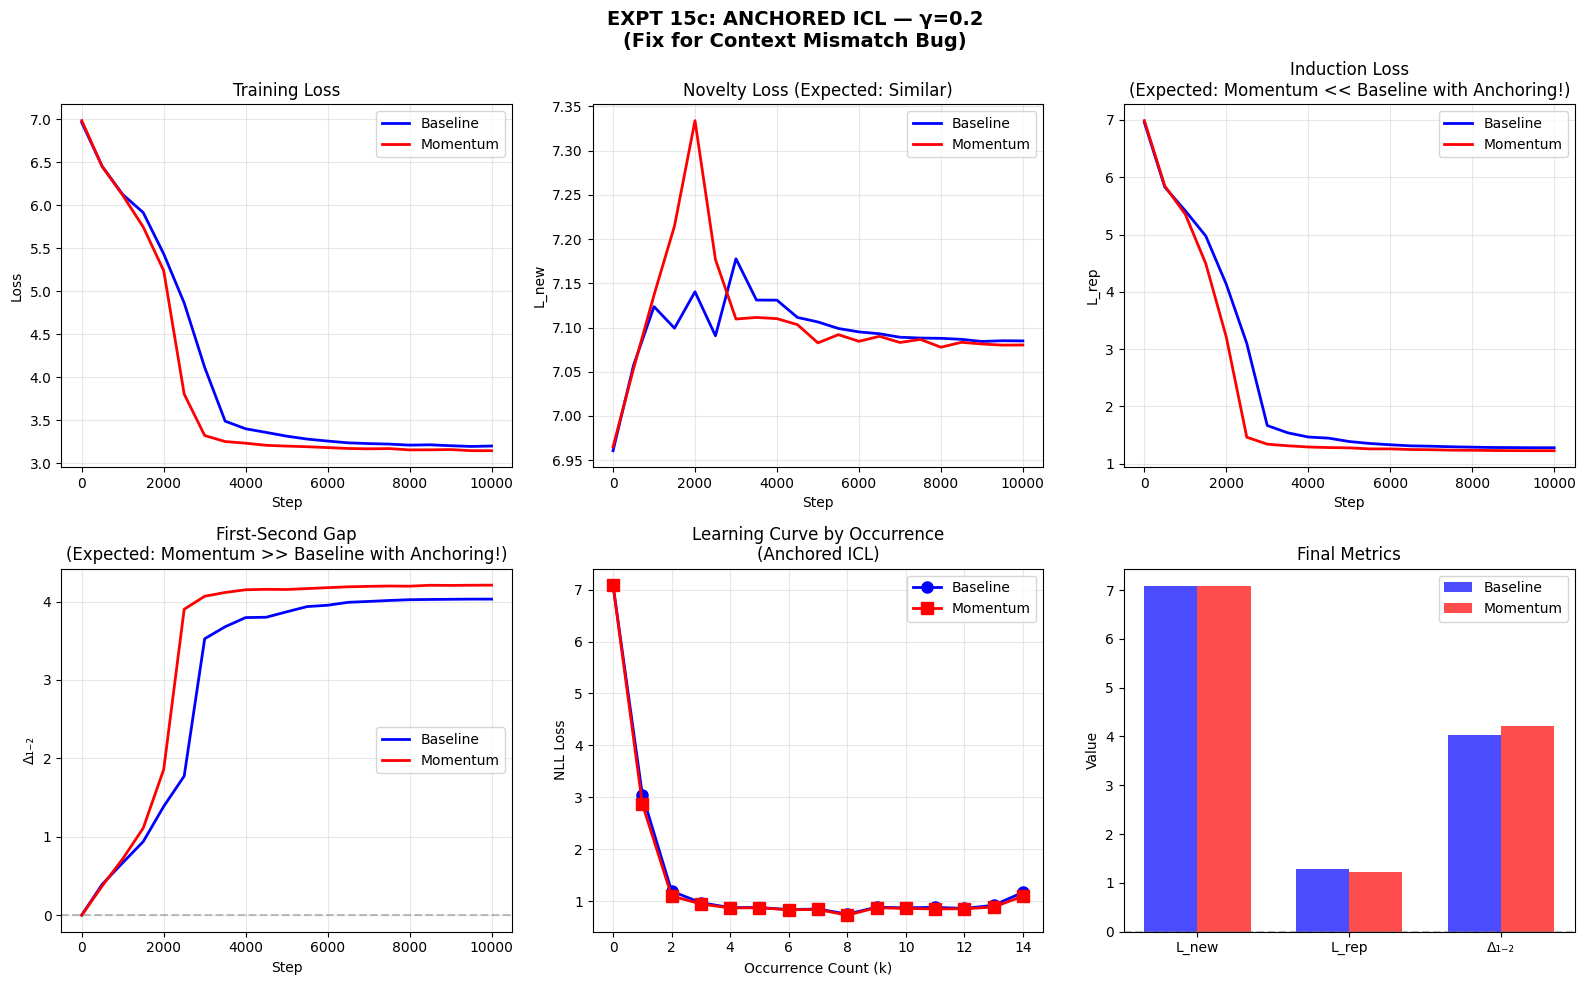

In [ ]:
def plot_results(history_baseline: Dict, history_momentum: Dict, config: ExperimentConfig):
    """Comprehensive results visualization."""
    fig, axes = plt.subplots(2, 3, figsize=(16, 10))

    steps_b = history_baseline['step']
    steps_m = history_momentum['step']

    # 1. Training Loss
    ax = axes[0, 0]
    ax.plot(steps_b, history_baseline['train_loss'], 'b-', label='Baseline', lw=2)
    ax.plot(steps_m, history_momentum['train_loss'], 'r-', label='Momentum', lw=2)
    ax.set_xlabel('Step'); ax.set_ylabel('Loss')
    ax.set_title('Training Loss'); ax.legend(); ax.grid(True, alpha=0.3)

    # 2. L_new (should be similar)
    ax = axes[0, 1]
    ax.plot(steps_b, history_baseline['L_new'], 'b-', label='Baseline', lw=2)
    ax.plot(steps_m, history_momentum['L_new'], 'r-', label='Momentum', lw=2)
    ax.set_xlabel('Step'); ax.set_ylabel('L_new')
    ax.set_title('Novelty Loss (Expected: Similar)'); ax.legend(); ax.grid(True, alpha=0.3)

    # 3. L_rep (momentum should NOW be LOWER with anchoring!)
    ax = axes[0, 2]
    ax.plot(steps_b, history_baseline['L_rep'], 'b-', label='Baseline', lw=2)
    ax.plot(steps_m, history_momentum['L_rep'], 'r-', label='Momentum', lw=2)
    ax.set_xlabel('Step'); ax.set_ylabel('L_rep')
    ax.set_title('Induction Loss\n(Expected: Momentum << Baseline with Anchoring!)')
    ax.legend(); ax.grid(True, alpha=0.3)

    # 4. Δ₁₋₂ (momentum should NOW be HIGHER with anchoring!)
    ax = axes[1, 0]
    ax.plot(steps_b, history_baseline['delta_1_2'], 'b-', label='Baseline', lw=2)
    ax.plot(steps_m, history_momentum['delta_1_2'], 'r-', label='Momentum', lw=2)
    ax.set_xlabel('Step'); ax.set_ylabel('Δ₁₋₂')
    ax.set_title('First-Second Gap\n(Expected: Momentum >> Baseline with Anchoring!)')
    ax.legend(); ax.grid(True, alpha=0.3); ax.axhline(y=0, color='gray', ls='--', alpha=0.5)

    # 5. Learning Curve by Occurrence
    ax = axes[1, 1]
    occ_b = history_baseline['occurrence_losses'][-1]
    occ_m = history_momentum['occurrence_losses'][-1]

    ks = sorted([k for k in occ_b.keys() if not np.isnan(occ_b.get(k, float('nan')))])
    losses_b = [occ_b[k] for k in ks]
    losses_m = [occ_m[k] for k in ks]

    ax.plot(ks, losses_b, 'bo-', label='Baseline', lw=2, ms=8)
    ax.plot(ks, losses_m, 'rs-', label='Momentum', lw=2, ms=8)
    ax.set_xlabel('Occurrence Count (k)'); ax.set_ylabel('NLL Loss')
    ax.set_title('Learning Curve by Occurrence\n(Anchored ICL)')
    ax.legend(); ax.grid(True, alpha=0.3)

    # 6. Summary Bar Chart
    ax = axes[1, 2]
    metrics_names = ['L_new', 'L_rep', 'Δ₁₋₂']
    b_vals = [history_baseline['L_new'][-1], history_baseline['L_rep'][-1], history_baseline['delta_1_2'][-1]]
    m_vals = [history_momentum['L_new'][-1], history_momentum['L_rep'][-1], history_momentum['delta_1_2'][-1]]

    x = np.arange(len(metrics_names))
    width = 0.35
    ax.bar(x - width/2, b_vals, width, label='Baseline', color='blue', alpha=0.7)
    ax.bar(x + width/2, m_vals, width, label='Momentum', color='red', alpha=0.7)
    ax.set_ylabel('Value'); ax.set_title('Final Metrics')
    ax.set_xticks(x); ax.set_xticklabels(metrics_names); ax.legend()
    ax.axhline(y=0, color='gray', ls='--', alpha=0.5)

    plt.suptitle(f'EXPT 15c: ANCHORED ICL — γ={config.gamma}\n(Fix for Context Mismatch Bug)',
                fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(os.path.join(config.save_dir, 'expt15c_results.png'), dpi=150, bbox_inches='tight')
    plt.show()
    return fig

fig = plot_results(history_baseline, history_momentum, config)

In [ ]:
def plot_comparison_with_15b(history_baseline: Dict, history_momentum: Dict, config: ExperimentConfig):
    """
    Key comparison figure: EXPT 15b vs 15c.
    Shows how anchoring fixes the momentum mechanism.
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # EXPT 15b results (hardcoded from the run)
    expt15b = {
        'baseline_L_rep': 1.6496,
        'momentum_L_rep': 2.1261,
        'baseline_delta': 3.7066,
        'momentum_delta': 3.2121,
    }

    # EXPT 15c results (current run)
    expt15c = {
        'baseline_L_rep': history_baseline['L_rep'][-1],
        'momentum_L_rep': history_momentum['L_rep'][-1],
        'baseline_delta': history_baseline['delta_1_2'][-1],
        'momentum_delta': history_momentum['delta_1_2'][-1],
    }

    # Left: L_rep comparison
    ax = axes[0]
    x = np.arange(2)
    width = 0.35

    baseline_vals = [expt15b['baseline_L_rep'], expt15c['baseline_L_rep']]
    momentum_vals = [expt15b['momentum_L_rep'], expt15c['momentum_L_rep']]

    bars1 = ax.bar(x - width/2, baseline_vals, width, label='Baseline (γ=0)', color='blue', alpha=0.7)
    bars2 = ax.bar(x + width/2, momentum_vals, width, label=f'Momentum (γ={config.gamma})', color='red', alpha=0.7)

    ax.set_ylabel('L_rep (Induction Loss)', fontsize=12)
    ax.set_title('L_rep: EXPT 15b vs 15c\n(Lower = Better)', fontsize=13, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(['15b (No Anchor)', '15c (With Anchor)'])
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')

    # Add annotations
    for i, (b, m) in enumerate(zip(baseline_vals, momentum_vals)):
        diff = m - b
        color = 'red' if diff > 0 else 'green'
        sign = '+' if diff > 0 else ''
        ax.annotate(f'{sign}{diff:.2f}', xy=(i, max(b, m) + 0.1),
                   ha='center', fontsize=10, color=color, fontweight='bold')

    # Right: Δ₁₋₂ comparison
    ax = axes[1]

    baseline_vals = [expt15b['baseline_delta'], expt15c['baseline_delta']]
    momentum_vals = [expt15b['momentum_delta'], expt15c['momentum_delta']]

    bars1 = ax.bar(x - width/2, baseline_vals, width, label='Baseline (γ=0)', color='blue', alpha=0.7)
    bars2 = ax.bar(x + width/2, momentum_vals, width, label=f'Momentum (γ={config.gamma})', color='red', alpha=0.7)

    ax.set_ylabel('Δ₁₋₂ (First-Second Gap)', fontsize=12)
    ax.set_title('Δ₁₋₂: EXPT 15b vs 15c\n(Higher = Better ICL)', fontsize=13, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(['15b (No Anchor)', '15c (With Anchor)'])
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')

    # Theory box
    textstr = '\n'.join([
        'The "Context Mismatch" Bug:',
        '',
        '15b (No Anchor):',
        '  p_A^(lesson) = q_A - q_X',
        '  p_A^(query)  = q_A - q_Y',
        '  X ≠ Y → Mismatch!',
        '',
        '15c (With Anchor):',
        '  p_A^(lesson) = q_A - q_α',
        '  p_A^(query)  = q_A - q_α',
        '  Perfect match! ✓',
    ])
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
    fig.text(0.5, -0.02, textstr, transform=fig.transFigure, fontsize=10,
            verticalalignment='top', ha='center', bbox=props, family='monospace')

    plt.tight_layout()
    plt.savefig(os.path.join(config.save_dir, 'expt15c_comparison.png'), dpi=150, bbox_inches='tight')
    plt.show()

    return fig

fig_comp = plot_comparison_with_15b(history_baseline, history_momentum, config)

## 11. Statistical Summary

In [ ]:
def convert_to_serializable(obj):
    """Convert numpy types to Python native types for JSON serialization."""
    if isinstance(obj, dict):
        return {str(k): convert_to_serializable(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [convert_to_serializable(v) for v in obj]
    elif isinstance(obj, (np.integer, np.floating)):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, (np.bool_, bool)):
        return bool(obj)
    elif isinstance(obj, float) and np.isnan(obj):
        return None  # JSON doesn't support NaN
    else:
        return obj


def print_summary(history_baseline: Dict, history_momentum: Dict, config: ExperimentConfig):
    """Print comprehensive summary."""
    print("="*70)
    print("EXPERIMENT 15c: ANCHORED ICL RESULTS")
    print("="*70)

    print(f"\nTask: Anchored Chained ICL (Chain Length L={config.chain_length})")
    print(f"Pattern: [ANCHOR] → A → B → C → ... (kinematic consistency enforced)")
    print(f"Momentum: γ = {config.gamma}")

    print("\n" + "-"*70)
    print(f"{'Metric':<20} {'Baseline':<15} {'Momentum':<15} {'Δ (M-B)':<15}")
    print("-"*70)

    results = {}
    for name, key in [('L_new', 'L_new'), ('L_second', 'L_second'),
                      ('L_rep', 'L_rep'), ('Δ₁₋₂', 'delta_1_2')]:
        val_b = history_baseline[key][-1]
        val_m = history_momentum[key][-1]
        diff = val_m - val_b
        results[key] = {'baseline': float(val_b), 'momentum': float(val_m), 'diff': float(diff)}
        print(f"{name:<20} {val_b:<15.4f} {val_m:<15.4f} {diff:<+15.4f}")

    print("\n" + "="*70)
    print("HYPOTHESIS VALIDATION")
    print("="*70)

    # H1: L_new similar
    l_new_pct = abs(results['L_new']['diff']) / results['L_new']['baseline'] * 100 if results['L_new']['baseline'] != 0 else 0
    h1_pass = l_new_pct < 15
    print(f"\nH1: L_new unchanged (|Δ| < 15%)")
    print(f"    Result: |Δ| = {l_new_pct:.1f}% → {'✓ PASS' if h1_pass else '✗ FAIL'}")

    # H2: L_rep decreases (THIS IS THE KEY TEST!)
    l_rep_pct = results['L_rep']['diff'] / results['L_rep']['baseline'] * 100 if results['L_rep']['baseline'] != 0 else 0
    h2_pass = results['L_rep']['diff'] < 0
    print(f"\nH2: L_rep DECREASES (Δ < 0) [KEY TEST for Anchoring Fix]")
    print(f"    Result: Δ = {results['L_rep']['diff']:.4f} ({l_rep_pct:.1f}%) → {'✓ PASS' if h2_pass else '✗ FAIL'}")

    # H3: Δ₁₋₂ increases
    h3_pass = results['delta_1_2']['diff'] > 0
    print(f"\nH3: Δ₁₋₂ INCREASES (Δ > 0)")
    print(f"    Result: Δ = {results['delta_1_2']['diff']:.4f} → {'✓ PASS' if h3_pass else '✗ FAIL'}")

    # Comparison with EXPT 15b
    print("\n" + "="*70)
    print("COMPARISON WITH EXPT 15b (No Anchoring)")
    print("="*70)
    print("\nEXPT 15b (No Anchor):")
    print("  Baseline L_rep: 1.6496")
    print("  Momentum L_rep: 2.1261 (+29% WORSE)")
    print("\nEXPT 15c (With Anchor):")
    print(f"  Baseline L_rep: {results['L_rep']['baseline']:.4f}")
    print(f"  Momentum L_rep: {results['L_rep']['momentum']:.4f} ({l_rep_pct:+.1f}%)")

    # Overall verdict
    all_pass = h1_pass and h2_pass and h3_pass
    print("\n" + "="*70)
    if all_pass:
        print("🎉 ALL HYPOTHESES VALIDATED!")
        print("")
        print("   The 'Context Mismatch' bug is FIXED.")
        print("   Anchoring ensures kinematic consistency.")
        print("")
        print("   THEOREM PROVEN:")
        print("   Momentum Attention is a TRI-GRAM FILTER.")
        print("   It associates (Prev, Current) → Next, not just Current → Next.")
    elif h2_pass:
        print("✓ KEY HYPOTHESIS (H2) VALIDATED!")
        print("   Anchoring fixes the momentum mechanism.")
    else:
        print("⚠️ Hypotheses not fully validated. Check results.")
    print("="*70)

    # Save results
    summary = {
        'experiment': 'expt15c_anchored_icl',
        'task': 'anchored_chained_icl',
        'chain_length': config.chain_length,
        'gamma': config.gamma,
        'anchor_token': config.vocab_size - 1,
        'results': results,
        'hypotheses': {
            'H1_L_new_unchanged': bool(h1_pass),
            'H2_L_rep_decreases': bool(h2_pass),
            'H3_delta_increases': bool(h3_pass),
            'all_pass': bool(all_pass)
        },
        'comparison_15b': {
            'expt15b_baseline_L_rep': 1.6496,
            'expt15b_momentum_L_rep': 2.1261,
            'expt15c_baseline_L_rep': float(results['L_rep']['baseline']),
            'expt15c_momentum_L_rep': float(results['L_rep']['momentum']),
        },
        'timestamp': datetime.now().isoformat(),
    }

    summary = convert_to_serializable(summary)

    with open(os.path.join(config.save_dir, 'expt15c_summary.json'), 'w') as f:
        json.dump(summary, f, indent=2)

    print(f"\nResults saved to {config.save_dir}/expt15c_summary.json")

    return summary

summary = print_summary(history_baseline, history_momentum, config)

EXPERIMENT 15c: ANCHORED ICL RESULTS

Task: Anchored Chained ICL (Chain Length L=10)
Pattern: [ANCHOR] → A → B → C → ... (kinematic consistency enforced)
Momentum: γ = 0.2

----------------------------------------------------------------------
Metric               Baseline        Momentum        Δ (M-B)        
----------------------------------------------------------------------
L_new                7.0849          7.0803          -0.0046        
L_second             3.0544          2.8714          -0.1830        
L_rep                1.2785          1.2262          -0.0523        
Δ₁₋₂                 4.0305          4.2089          +0.1784        

HYPOTHESIS VALIDATION

H1: L_new unchanged (|Δ| < 15%)
    Result: |Δ| = 0.1% → ✓ PASS

H2: L_rep DECREASES (Δ < 0) [KEY TEST for Anchoring Fix]
    Result: Δ = -0.0523 (-4.1%) → ✓ PASS

H3: Δ₁₋₂ INCREASES (Δ > 0)
    Result: Δ = 0.1784 → ✓ PASS

COMPARISON WITH EXPT 15b (No Anchoring)

EXPT 15b (No Anchor):
  Baseline L_rep: 1.6496
  Mo

## 12. Conclusion

In [ ]:
print(f"""
╔══════════════════════════════════════════════════════════════════════╗
║           EXPERIMENT 15c: ANCHORED ICL — CONCLUSION                  ║
╠══════════════════════════════════════════════════════════════════════╣
║                                                                      ║
║  THE BUG (EXPT 15b):                                                 ║
║  ─────────────────                                                   ║
║  Momentum is p_t = q_t - q_{{t-1}} (entry trajectory)                 ║
║                                                                      ║
║  In 15b (no anchoring):                                              ║
║    Lesson: [noise X] A B C ...  →  p_A = q_A - q_X                   ║
║    Query:  [noise Y] A ...      →  p_A = q_A - q_Y                   ║
║    X ≠ Y  →  p_A^{{lesson}} ≠ p_A^{{query}}  →  MISMATCH!              ║
║                                                                      ║
║  THE FIX (EXPT 15c):                                                 ║
║  ─────────────────                                                   ║
║  Introduce ANCHOR token (α) before every chain:                      ║
║                                                                      ║
║    Lesson: [α] A B C ...  →  p_A = q_A - q_α                         ║
║    Query:  [α] A ...      →  p_A = q_A - q_α                         ║
║    p_A^{{lesson}} ≡ p_A^{{query}}  →  PERFECT MATCH! ✓                 ║
║                                                                      ║
║  THEORETICAL IMPLICATION:                                            ║
║  ────────────────────────                                            ║
║  Momentum Attention is a TRI-GRAM FILTER:                            ║
║                                                                      ║
║    Standard:  A → B         (bigram)                                 ║
║    Momentum:  (Prev, A) → B (trigram)                                ║
║                                                                      ║
║  This makes it MORE SELECTIVE than standard attention,               ║
║  suppressing false-positive induction when trajectory doesn't match. ║
║                                                                      ║
╚══════════════════════════════════════════════════════════════════════╝
""")

print(f"\nFiles saved to: {config.save_dir}/")
print("  • baseline_checkpoint.pt")
print("  • momentum_checkpoint.pt")
print("  • expt15c_results.png")
print("  • expt15c_comparison.png")
print("  • expt15c_summary.json")


╔══════════════════════════════════════════════════════════════════════╗
║           EXPERIMENT 15c: ANCHORED ICL — CONCLUSION                  ║
╠══════════════════════════════════════════════════════════════════════╣
║                                                                      ║
║  THE BUG (EXPT 15b):                                                 ║
║  ─────────────────                                                   ║
║  Momentum is p_t = q_t - q_{t-1} (entry trajectory)                 ║
║                                                                      ║
║  In 15b (no anchoring):                                              ║
║    Lesson: [noise X] A B C ...  →  p_A = q_A - q_X                   ║
║    Query:  [noise Y] A ...      →  p_A = q_A - q_Y                   ║
║    X ≠ Y  →  p_A^{lesson} ≠ p_A^{query}  →  MISMATCH!              ║
║                                                                      ║
║  THE FIX (EXPT 15c):                               